# ALS Fitting Code Template: H<sub>2</sub>O<sub>2</sub> Photolysis Example

This notebook serves as an example of how to use the ALS.KineticModel class ('ALS.py') to fit kinetics data.  Documentation for the class methods is provided throughout.  An example of a user kinetic model (passed to the ALS.KineticModel instantiator) is provided for the H<sub>2</sub>O<sub>2</sub> photolysis system in 'ex_model_1.py'.  It is recommended to use this notebook and  the example user model file as templates, modifying them to construct and fit new models.

**Whenever a cell in this notebook is modified, it must be rerun.**  It is also necessary to rerun any other cells that rely on values computed in the modified cell.  For example, if the code for step 1 of a setup task is modified, you will likely need to rerun cells for all steps of that setup task.

The goal of the fit is to solve the following optimization problem:

$$\vec{p}_{opt} = \underset{\vec{p}}{\arg\min} \sum_{i\in\{species\}} w_i \cdot \bigg[ \sum_{t_j\in\{t\}} \Big( \frac{y_{i,obs}(t_j) - y_{i,mod}(t_j, \vec{p})}{y_{i,err}(t_j)} \Big)^2 \bigg]$$
Where:
 - $\vec{p}_{opt}$ is the optimized parameter vector.
 - $w_i$ is the scalar weight of species $i$ in the cost function.
 - $y_{i,obs}(t_j)$ is the observed signal of species $i$ at time $t_j$.
 - $y_{i,err}(t_j)$ is the uncertainty in the observed signal of species $i$ at time $t_j$.
 - $y_{i,mod}(t_j, \vec{p})$ is the modeled signal of spceies $i$ at time $t_j$.  It is computed by integrating the user model in steps dictated by the photolysis gradient, convolving the concentration profiles with the instrument response function (IRF), and finally scaling by a species-specific scale factor ${S_i}$ to convert from concentration units to ion signal.

***Advice on performing fits:***

Like most nonlinear fits, the results can be highly sensitive to the choice of initial guess, particularly as the number of fitted parameters increases.  Some tips if your results seem overly sensitive to the initial guess:

1. Use the ALS.KineticModel.plot_data_model method to check that your initial guess is reasonable.  If you're unable to get something visually close by adjusting the initial guess, then it's a good indication that your model is not describing the phenomena you are trying to capture, some fixed parameters are inaccurate, etc.  I've found that the results are much more sensitive to initial guess when the fit quality is visually poor.

2. Consider the uncertainties on the optimized parameters.  Do the results change substantially as the initial guess is varied, or are they all within error?  The bootstrap method tends to produce substantially more accurate (and larger) uncertainties than those determined from the estimated fit Jacobian.

3. Also consider the covariance between parameters.  If an optimized parameter changes as the initial guess is varied, does a parameter to which it is highly correlated also change?  This suggests your model / data cannot independently determine these parameters, and they might only be varying within error (see above point).

4. Try changing the ftol, xtol, or maxfev arguments passed to the leastsq solver (identify which is causing the solver to terminate) to achieve tighter convergence criteria.  Although in practice, I haven't seen this make much of a difference.

***Other tips:***

 - Setting *err_weight* to False tends to give better visual fit quality when some fitted species have worse signal-to-noise than others.  (For example, in this notebook, OH has poor signal-to-noise and its fit looks visually incorrect if *err_weight* is True.)
 - This code can also be used to fit non-ALS kinetics data, so long as all time points are integer multiples of 0.02 ms.  Simply set the *apply_IRF* and *apply_PG* flags to False.  If there is no photolysis offset in the non-ALS experiment, then fix *t0* at 0.  The interpretation species-specific scale factor ${S_i}$ will no longer be related to the photoionization cross section, but instead to details of the non-ALS epxeriment.

# Setup: Modules

Be sure to run this code block first.  Imports all of the modules necessary for the rest of the notebook.  Note that the ALS module also has matplotlib and scipy as dependencies, even though we do not need to import them within this notebook.

This example notebook was developed and tested using the following packages/versions.  Other versions may also work.    
 - python (3.6.1)
 - numpy (1.12.1)
 - pandas (0.20.1)
 - scipy (0.19.0)
 - matplotlib (2.2.2)
 - ipython (5.3.0)
 - ALS (1.0.0)

In [2]:
import numpy as np
import pandas as pd
from IPython.display import display
import ALS

# Setup: User Model

#### Step 1: Define the user model. 

This is the step that requires the most coding on behalf of the user.  I prefer to code the user model in a separate text editor (Sublime Text), save it as a module, and then import it.  The 'ex_model_1.py' file contains the example model_H2O2_depletion with comments providing an explanation how to structure the user model.  It is recommended to follow the template provided there, although any function that has the correct arguments / returns (see below) will work.

*function* **user_model**(*t, model_params*)

**Parameters:**

>**t : *ndarray***
>>Time axis (ms) over which to integrate the model.

>**model_params : *dict***
>>Keys (strings) are the names of the parameters used by the model; values (floats) are the parameter values.  Any parameters that will be fit or included in a monte carlo simulation of systematic error should be included.  Only one parameter is required: 'X0' is the key and the initial radical concentration is its value.

**Returns:** It is only required to return species for which there is observable data to fit; returning other species from the model is optional, but could be useful when plotting model output.  The keys of *m* and *c* must be the same.

>**m : *dict***
>>Keys (strings) are the names of species returned by the model; values (floats) are their masses (amu).

>**c : *dict***
>>Keys (strings) are the names of species returned by the model; values (ndarray) are concentrations (molc/cm<sup>3</sup>) corresponding to times in *t*.

In [3]:
from ex_model_1 import model_H2O2_depletion

#### Step 2: Instantiate the KineticModel object.

*class* **ALS.KineticModel**(*user_model, err_weight=True, fit_pre_photo=False, apply_IRF=True, apply_PG=True, t_PG=1.0*)

**Parameters:**

>**user_model : *function***
>>The user model function defined in Step 1.

>**err_weight : *bool, optional***
>> If True, the contribution of each data point to the fit cost function is weighted by its uncertainty.  If False, then the error terms are omitted.  (See cost function in the introduction.)

>**fit_pre_photo : *bool, optional***
>> If True, the fit cost function is calculated across all *t*.  If False, the fit cost function is calculated only using data for which *t* ≥ *t0*.  If *t0* is being fit, then this MUST be set to True.  While every model is different, this should generally be left at the default value of False unless *t0* is being fit.

>**apply_IRF : *bool, optional***
>> If True, then the output of the model integration will be convolved with the IRF.

>**apply_PG : *bool, optional***
>> If True, then the model will be integrated in steps (set by *t_PG*) with a linearly changing initial radical concentration.

>**t_PG : *float, optional***
>>The step size (ms) used for updating the radical concentration and implementing the photolysis gradient.  Required to be an integer multiple of 0.02 ms; recommended to be an integer multiple of *tbin* \* 0.02 ms.  Smaller values will give more accurate results but increase computation time.  The default value of 1 ms is often a good tradeoff.  Ignored if *apply_PG* is False.

In [4]:
model = ALS.KineticModel(model_H2O2_depletion, err_weight=False)

# Setup: Species Data

#### Step 1: Load the species data

This is a workspace to load the data.  The time axis (*t*), *tbin*, *t_start*, and *t_end* are also defined for passing to the ALS.KineticModel methods.  This can be customized or the template below can be followed.

The data can have any units (typically ion counts or normalized ion signal); this example uses ion counts.  The scaling of the signal to concentration units is handled in the ALS parameters setup section below.

The template assumes that kinetics traces were extracted for each species over the entire time interval [-20 ms, 130 ms) with step size of *tbin* \* 0.02 ms.  The column headers are the names of the species.  The 'val' file contains the data values and the 'err' file contains the corresponding uncertainties.  See 'ex_data_val_1.csv' and 'ex_data_err_1.csv' for an example of the formatting.

In [5]:
# Inputs
tbin = 10                    # tbin used when data was extracted using Igor
t_start = -20                # Will trim the data to t_start inclusive (ms) - must be integer multiple of tbin * 0.02 ms
t_end = 59.8                 # Will trim the data to t_end inclusive (ms) - must be integer multiple of tbin * 0.02 ms
fn_val = 'ex_data_val_1.csv' # Filename for the data values
fn_err = 'ex_data_err_1.csv' # Filename for the uncertainties

# Step size of time axis (ms)
delta_t = tbin * 0.02                    

# Calculate the time axis [-20 ms, 130 ms)
t = np.linspace(-20,130,num=int(150/(dt*tbin)),endpoint=False)

# Load the data values and uncertainties
df_val = pd.read_csv(fn_val)
df_err = pd.read_csv(fn_err)

# Determine indices of data to drop
idx_start = np.abs(t-t_start).argmin()
idx_end = np.abs(t-t_end).argmin()
drop_indices = np.concatenate((np.arange(idx_start),np.arange(idx_end+1,t.size)))

# Trim the time axis and data to [t_start, t_end]
t = t[idx_start:idx_end+1]
df_val = df_val.drop(drop_indices, axis=0).reset_index(drop=True)
df_err = df_err.drop(drop_indices, axis=0).reset_index(drop=True)

#### Step 2: Organize species data into a DataFrame

The *data* DataFrame will be passed to the ALS.KineticModel methods.  Rows correspond to each species; the indices are species names and must match a species name returned by the user model.  The columns are detailed below.  If you used the recommended template from Step 1, then you can also follow the template below.

**Columns:**

>**val : *ndarray***
>>Array containing the signal for the species.  This is $y_{i,obs}(t)$ using the notation of the introduction.

>**err : *ndarray***
>>Array containing the signal uncertainties.  This is $y_{i,err}(t)$ using the notation of the introduction.

>**fit : *bool***
>>If True, this species is included in the calculation of the fit cost function.  If False, then it is omitted.

>**weight : *float***
>>The scalar weight of the species in the cost function.  This is $w_i$ using the notation of the introduction.

In [14]:
data = {}
data['H2O2'] = {'val':df_val['H2O2'].values, 'err':df_err['H2O2'].values, 'fit':True, 'weight':1.0}
data['HO2']  = {'val':df_val['HO2'].values,  'err':df_err['HO2'].values,  'fit':True, 'weight':1.0}
data['OH']   = {'val':df_val['OH'].values,   'err':df_err['OH'].values,   'fit':False, 'weight':1.0}

data = pd.DataFrame.from_dict(data, orient='index')
display(data)

,val,err,fit,weight
H2O2,"[6135.0, 6162.0, 6025.0, 6005.0, 6027.0, 6101....","[78.326, 78.498, 77.621, 77.492, 77.634, 78.10...",True,1.0
HO2,"[-3.15, -4.15, -3.15, -4.15, 5.85, 6.85, -1.15...","[5.0, 4.899, 5.0, 4.899, 5.831, 5.9161, 5.1962...",True,1.0
OH,"[-0.82, 0.18, 0.18, -0.82, -0.82, -0.82, 1.18,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.4142, 1.0, 1....",False,1.0


# Setup: Model and ALS Parameters

In [13]:
c_H2O2_0 = 5.25e14
idx_zero = np.abs(t-(-1.68)).argmin()
S_H2O2 = df_val.iloc[:idx_zero,df_val.columns.get_loc('H2O2')].mean() / c_H2O2_0

model_params = {}
model_params['X0'] =         {'val':4.2e12,     'err':0,  'fit':True}
model_params['k_OH_wall'] =  {'val':25,        'err':0, 'fit':False}
model_params['k_HO2_wall'] = {'val':6,        'err':0, 'fit':True}
model_params['T'] =          {'val':298.,       'err':0,  'fit':False}
model_params['P'] =          {'val':30.,        'err':0,  'fit':False}
model_params['c_H2O2_0'] =   {'val':c_H2O2_0,   'err':0,  'fit':False}
model_params = pd.DataFrame.from_dict(model_params, orient='index')

print('Inputted Model Params:')
display(model_params)

ALS_params = {}
ALS_params['S_H2O2'] =  {'val':S_H2O2,    'err':0, 'fit':False}
ALS_params['S_OH'] =    {'val':3.6e-11,     'err':0, 'fit':False}
ALS_params['S_HO2'] =   {'val':2.6e-10,     'err':0, 'fit':True}
ALS_params['A'] =       {'val':-0.022,  'err':0, 'fit':False}
ALS_params['B'] =       {'val':4.85e-3,   'err':0, 'fit':False}
ALS_params['t0'] =      {'val':-0.5,     'err':0, 'fit':False}
ALS_params = pd.DataFrame.from_dict(ALS_params, orient='index')

print('Inputted ALS Params:')
display(ALS_params)

Inputted Model Params:


,val,err,fit
P,3.000000e+01,0,False
T,2.980000e+02,0,False
X0,4.200000e+12,0,True
c_H2O2_0,5.250000e+14,0,False
k_HO2_wall,6.000000e+00,0,True
k_OH_wall,2.500000e+01,0,False


Inputted ALS Params:


,val,err,fit
A,-2.200000e-02,0,False
B,4.850000e-03,0,False
S_H2O2,1.149961e-11,0,False
S_HO2,2.600000e-10,0,True
S_OH,3.600000e-11,0,False
t0,-5.000000e-01,0,False


# Method: Plot the model in concentration units

Integrates the user model with the model and ALS parameters specified above (no fitting).  The output is plotted (and optionally saved) in concentration units.  All species returned by the user model are plotted, regardless of the 'fit' field in the species dataframe.  If *apply_IRF* and *apply_PG* are set to False, then this is equivalent to running a Kintecus model.  Since coding the rate equations may be tedious for larger models, it is recommended to compare this output to an equivalent Kinteucs model to ensure that the model was coded correctly.

See the file 'ex_init_model_conc_1.csv' for an example of how the output is formatted if *save_fn* is specified.

*method* **ALS.KineticModel.plot_model**(*t_start, t_end, tbin, model_params, ALS_params, delta_xtick=20.0, save_fn=None*)

**Parameters:**

>**t_start : *float***
>>Start time (ms) for the plot.  Must be an integer multiple of *tbin* \* 0.02 ms and cannot be less than -20 ms.

>**t_end : *float***
>>End time (ms) for the plot.  Must be an integer multiple of *tbin* \* 0.02 ms and must be greater than *t_start*.

>**tbin : *int***
>>The time axis step size will be *tbin* \* 0.02 ms.

>**model_params : *DataFrame***
>>Contains the model parameters.  See setup above for formatting.

>**ALS_params : *DataFrame***
>>Contains the ALS parameters.  See setup above for formatting.

>**delta_xtick : *float, optional***
>>Tick marks and labels for the time axis include zero and are spaced by *delta_xtick* (ms).

>**save_fn : *str, optional***
>>The data in the plots are saved to *save_fn* if this parameter is specified.  First column is the time axis (ms) and the remaining columns contain the concentrations (molc/cm<sup>3</sup>) for each species.

<IPython.core.display.Javascript object>


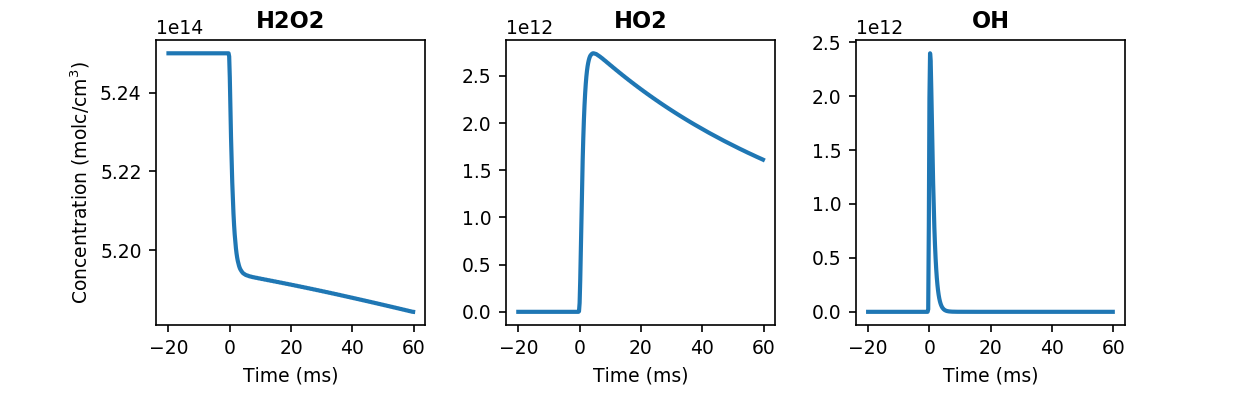

In [12]:
% matplotlib notebook

model.plot_model(t_start, t_end, tbin, model_params, ALS_params, save_fn='ex_init_model_conc_1.csv')

# Method: Plot the data overlaid with the scaled model

Use cases:
1. plotting a previous fit without having to rerun the fit code\n
2. playing around with initial guesses before performing a fit\n
3. saving optimized model * scale factor for each species in order to plot elsewere

<IPython.core.display.Javascript object>


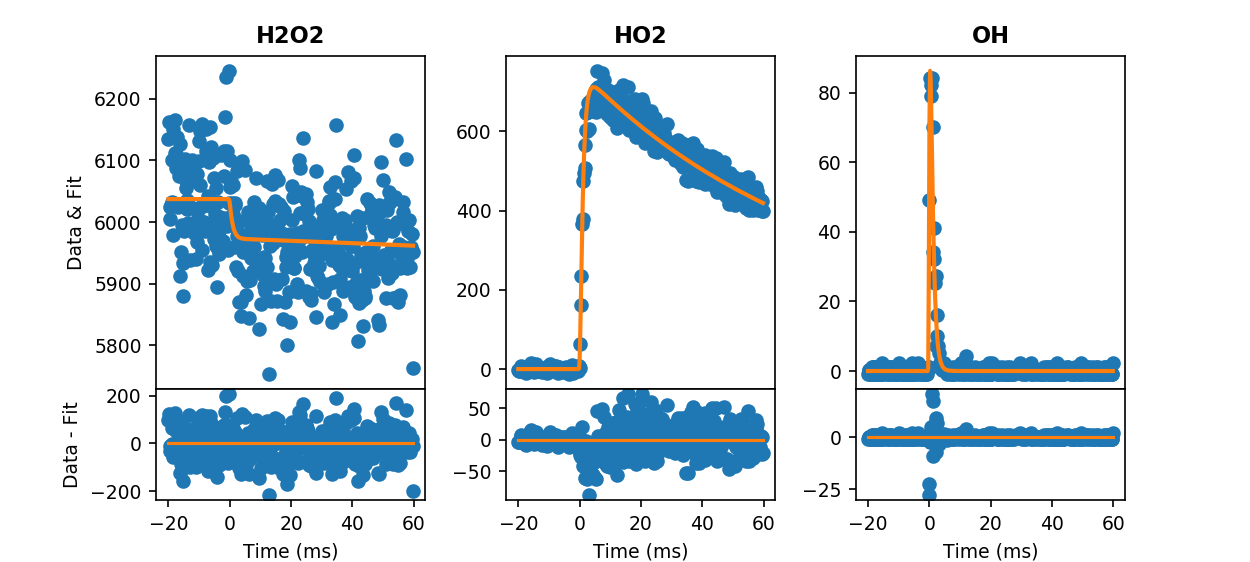


Cost Function Value = 1.55088e+06


In [9]:
% matplotlib notebook

model.plot_data_model(t, tbin, data, model_params, ALS_params, save_fn='ex_init_model_scaled_1.csv')

# Perform a fit

Optimization terminated successfully.
Exit Code = 1
Exit Message = Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000

Optimized Cost Function Value = 1.53796e+06

Optimized Parameters and Standard Errors:


,val,err
X0,4.421938e+12,9.960795e+10
k_HO2_wall,5.317556e+00,1.326875e-01
S_HO2,2.485376e-10,3.841785e-12



Correlation Matrix:


,X0,k_HO2_wall,S_HO2
X0,1.000000,-0.468595,-0.937322
k_HO2_wall,-0.468595,1.000000,0.515645
S_HO2,-0.937322,0.515645,1.000000


<IPython.core.display.Javascript object>


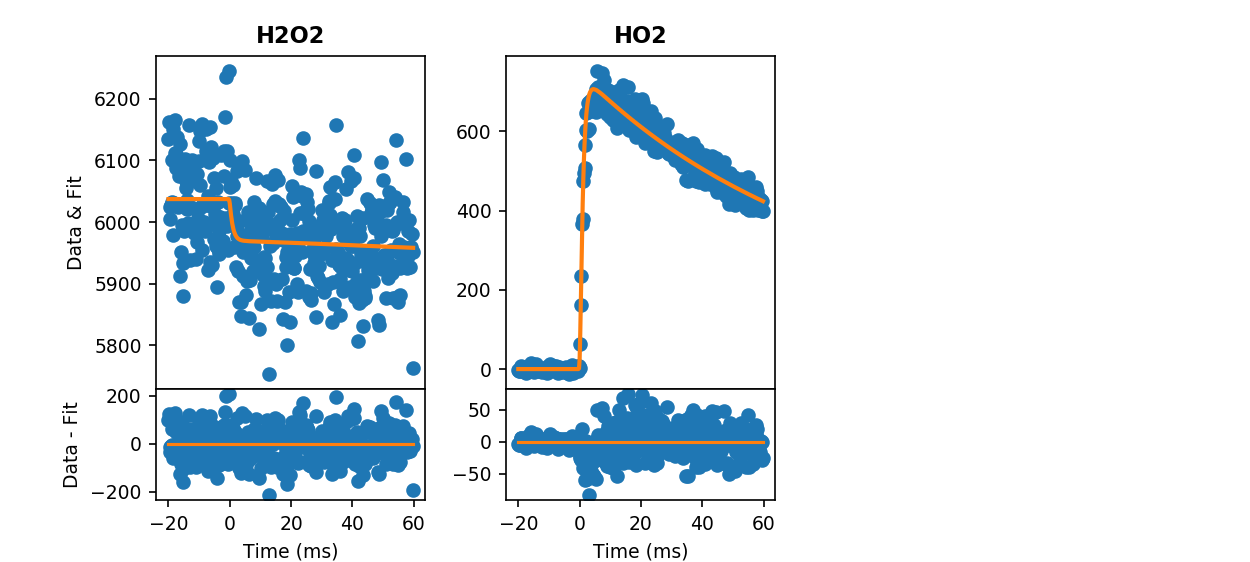

In [15]:
% matplotlib notebook

df_p, df_cov_p, df_corr_p, cost, mesg, ier \
    = model.fit(t, tbin, data, model_params, ALS_params, save_fn='ex_fit_model_scaled_1.csv')

In [13]:
import importlib
importlib.reload(ALS)
model = ALS.KineticModel(model_H2O2_depletion, err_weight=False)